In [49]:
import copy
import torch
import shutil
import os 
import gc
import re

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from tqdm import tqdm
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchmetrics.classification import F1Score
from torch.optim.lr_scheduler import OneCycleLR
from collections import Counter
from torchinfo import summary

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Устройство для обучения
device

device(type='cuda')

# Настройка параметров

In [51]:
pretrained = False  # Пропустить обучение модели

train_path = './simpsons_train'  # Путь к директории с тренировочным датасетом
test_path  = './simpsons_test'   # Путь к директории с тестовым датасетом

size = 224                    # До какого размера изменить входное изображение
mean = [0.485, 0.456, 0.406]  # Среднее значение для нормирования каналов
std  = [0.229, 0.224, 0.225]  # Стандратное отклонение для нормирования каналов

valid_size = 0.1  # Доля валидационной части

num_epochs = 30
batch_size = 64
lr = 0.1

# Параметры оптимизатора
momentum = 0.9

# Параметры планировщика
max_lr = 0.1

In [52]:
# Преобразование изображений
transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std)]) # Нормирование каждого канала изображения

# Подготовка тестового датасета

In [53]:
files = os.listdir(test_path)

for file in files: 

    if os.path.isdir(test_path + '/' + file): # Пропустить все папки в директории
        continue

    match = re.search(r'[a-z_]+', file) # Отобрать от названия файлов только имена персонажей

    if match != None:

        name = match.group(0)[:-1] # Обрезать последнее нижнее подчеркивание

        if not os.path.exists(test_path + '/' + name): # Создать папку с именем персонажа, если она ещё не существует        
            os.mkdir(test_path + '/' + name)

        shutil.move(test_path + '/' + file, test_path + '/' + name) # Перенести все изображения с именем персонажа в созданную папку

## Создание датасетов

In [54]:
# Создание датасетов
dataset      = ImageFolder(train_path, transform = transform)
test_dataset = ImageFolder(test_path, transform = transform)

n_val   = int(np.floor(valid_size * len(dataset))) # Количество изображений в валидационном датасете
n_train = len(dataset) - n_val                     # Количество изображений в тренировочном датасете
n_test  = len(test_dataset)                        # Количество изображений в тестовом датасете

# Разделение тренировочного датасета для получения валидационного
train_dataset, val_dataset = random_split(dataset, [n_train, n_val])

## Нахождение весов каждого класса

In [55]:
ids = train_dataset.indices              # Индексы изображений в датасете
nums = [dataset.targets[i] for i in ids] # Сопоставить каждому индексу изображений соответсвующий номер класса

samples = list(Counter(sorted(nums)).values()) # Количество изображений в каждом классе

weights = [samples[i] / sum(samples) for i in range(len(samples))] # Веса каждого класса
weights = torch.FloatTensor(weights)

## Создание тренировочного, валидационного и тестового загрузчиков 

In [56]:
# Создание загрузчиков
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = 1)
valid_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True, num_workers = 1)
test_loader  = DataLoader(test_dataset, batch_size = batch_size, shuffle = True, num_workers = 1)

# Классы в датасетах
train_classes = dataset.classes
test_classes  = test_dataset.classes

# Сопоставить номера классов тестового датасета с номерами
# тренировочного датасета
classes_dict = {test_dataset.class_to_idx[cls] : dataset.class_to_idx[cls]  for cls in test_classes}

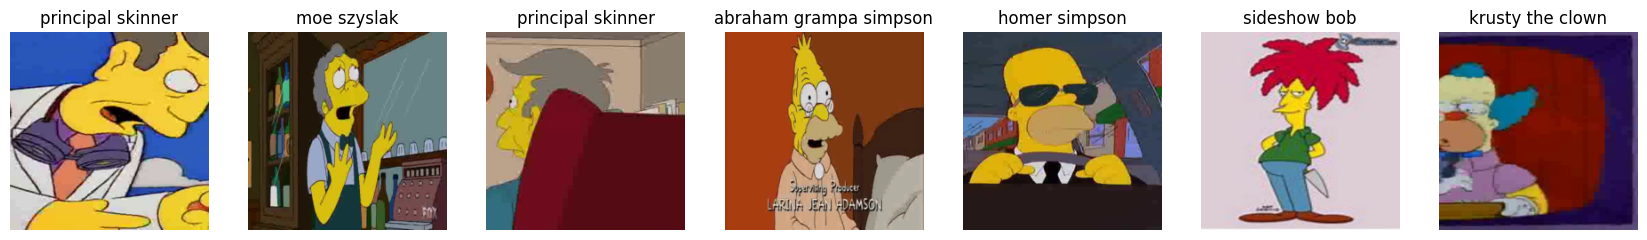

In [57]:
# Вывод заданного количества изображений
def imshow(images, labels, cnt):

    # Подготовка холста для изображений
    fig, axs = plt.subplots(1, cnt) 
    fig.set_figwidth(cnt * 3)

    for i, image in enumerate(images[:cnt]):
        
        # Разнормировать изображения
        for chn in range(3):
            image[chn] = image[chn] * std[chn] + mean[chn]

        # Приведение массива к формату (H, W, Ch)
        npimg = image.numpy()
        npimg = np.transpose(npimg, (1, 2, 0)).squeeze()

        ax = axs[i] if cnt > 1 else axs

        # Вывод изображения
        ax.set_title(train_classes[labels[i]].replace('_', ' '))
        ax.set_axis_off()
        ax.imshow(npimg)

    plt.show()
   
# Получить случайные тренировочные изображения
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(images, labels, 7)

# Реализация ResNet

In [58]:
class ResidualBlock(nn.Module):

    def __init__(self, in_channels, inter_channels, out_channels, stride, downsample = None):
        super(ResidualBlock, self).__init__()
        self.out_channels = out_channels
        self.downsample = downsample
        
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, inter_channels, kernel_size = 1, stride = stride),
                        nn.BatchNorm2d(inter_channels),
                        nn.ReLU(True))

        self.conv2 = nn.Sequential(
                        nn.Conv2d(inter_channels, inter_channels, kernel_size = 3, padding = 1),
                        nn.BatchNorm2d(inter_channels),
                        nn.ReLU(True))
        
        self.conv3 = nn.Sequential(
                        nn.Conv2d(inter_channels, out_channels, kernel_size = 1),
                        nn.BatchNorm2d(out_channels))
        
        self.relu = nn.ReLU(True)
        
    def forward(self, x):

        residual = x

        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)

        if self.downsample:
            residual = self.downsample(x)
            
        out += residual
        out = self.relu(out)

        return out  

In [59]:
class ResNet50(nn.Module):

    def __init__(self, num_classes):
        super(ResNet50, self).__init__()
        
        self.layers = [3, 6, 4, 3]
        self.block = ResidualBlock
        self.in_channels = 64
        
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(self.in_channels),
                        nn.ReLU(True))
        
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        self.layer0 = self._make_layer(self.block, 64, 256, self.layers[0], stride = 2)
        self.layer1 = self._make_layer(self.block, 128, 512, self.layers[1], stride = 2)
        self.layer2 = self._make_layer(self.block, 256, 1024, self.layers[2], stride = 2)
        self.layer3 = self._make_layer(self.block, 512, 2048, self.layers[3], stride = 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, num_classes)

    def _make_layer(self, block, inter_channels, out_channels, blocks, stride):
        
        downsample = nn.Sequential(
                        nn.Conv2d(self.in_channels, out_channels, kernel_size = 1, stride = stride),
                        nn.BatchNorm2d(out_channels))

        layers = []
        layers.append(block(self.in_channels, inter_channels, out_channels, stride, downsample))

        self.in_channels = out_channels
        
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, inter_channels, out_channels, stride = 1))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.maxpool(x)

        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x 

## Создание модели

In [60]:
net = ResNet50(len(train_classes)).to(device)

# Загрузить сохраненные веса в модель
if pretrained:
    net.load_state_dict(torch.load('./weights.h5'))

# Функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss(weight = weights).to(device)
optimizer = torch.optim.SGD(net.parameters(), lr = lr, momentum = momentum)
schedule = OneCycleLR(optimizer, max_lr = max_lr, steps_per_epoch = n_train, epochs = num_epochs)

#summary(net, input_size = (batch_size, 3, size, size))

# Обучение модели

In [61]:
if not pretrained:

    # Значения функции потерь в течение обучения
    train_losses = np.zeros(num_epochs) 
    val_losses   = np.zeros(num_epochs)

    # Значения F1 в течение обучения
    train_f1s = np.zeros(num_epochs) 
    val_f1s   = np.zeros(num_epochs)

    # Значения learning rate в течение обучения
    lrs = []

    for epoch in (pbar := tqdm(range(num_epochs))):
        
        best_weights = copy.deepcopy(net.state_dict())
        best_f1 = 0

        train_f1 = F1Score(task = 'multiclass', num_classes = len(train_classes), average = 'macro').to(device)
        val_f1   = F1Score(task = 'multiclass', num_classes = len(train_classes), average = 'none').to(device)

        net.train()

        for images, labels in train_loader:  

            # Отправить тензоры на выбранное устройство для обучения
            images = images.to(device)
            labels = labels.to(device)
            
            # Прямой проход
            outputs = net(images)
            loss = criterion(outputs, labels)           
            train_losses[epoch] += loss

            _, predicted = torch.max(outputs.data, 1)

            train_f1.update(predicted, labels)

            # Обратный проход и оптимизация
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            lrs.append(optimizer.param_groups[0]["lr"])
            schedule.step()
            
            # Очистить память
            del images, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()

        train_f1s[epoch] = 100 * train_f1.compute()
        train_losses[epoch] /= len(train_loader)  
        # Валидация
        with torch.no_grad():

            net.eval()

            for images, labels in valid_loader:

                images = images.to(device)
                labels = labels.to(device)

                outputs = net(images)
                loss = criterion(outputs, labels)
                val_losses[epoch] += loss

                _, predicted = torch.max(outputs.data, 1)
                
                val_f1.update(predicted, labels)

                del images, labels, outputs
                torch.cuda.empty_cache()
                gc.collect()

            val_losses[epoch] /= len(valid_loader)
            val_f1s[epoch] = 100 * sum(val_f1.compute()) / val_f1.compute().count_nonzero()

            # Сохранение весов, если результат на текущей эпохе лучше
            if best_f1 < val_f1s[epoch]:
                best_f1 = val_f1s[epoch]
                best_weights = copy.deepcopy(net.state_dict())

        del train_f1, val_f1
        torch.cuda.empty_cache()
        gc.collect()

        pbar.set_description(f'Avg. train/valid loss: [{train_losses[epoch].item():.2f}/{val_losses[epoch].item():.2f}], train/valid F1: [{train_f1s[epoch]:.2f}%/{val_f1s[epoch]:.2f}%]')

    # Загрузка и сохранение лучших весов
    net.load_state_dict(best_weights)
    torch.save(net.state_dict(), './weights.h5')


Avg. train/valid loss: [0.02/0.62], train/valid F1: [66.44%/77.27%]: 100%|██████████| 30/30 [30:18<00:00, 60.60s/it]


## Графики

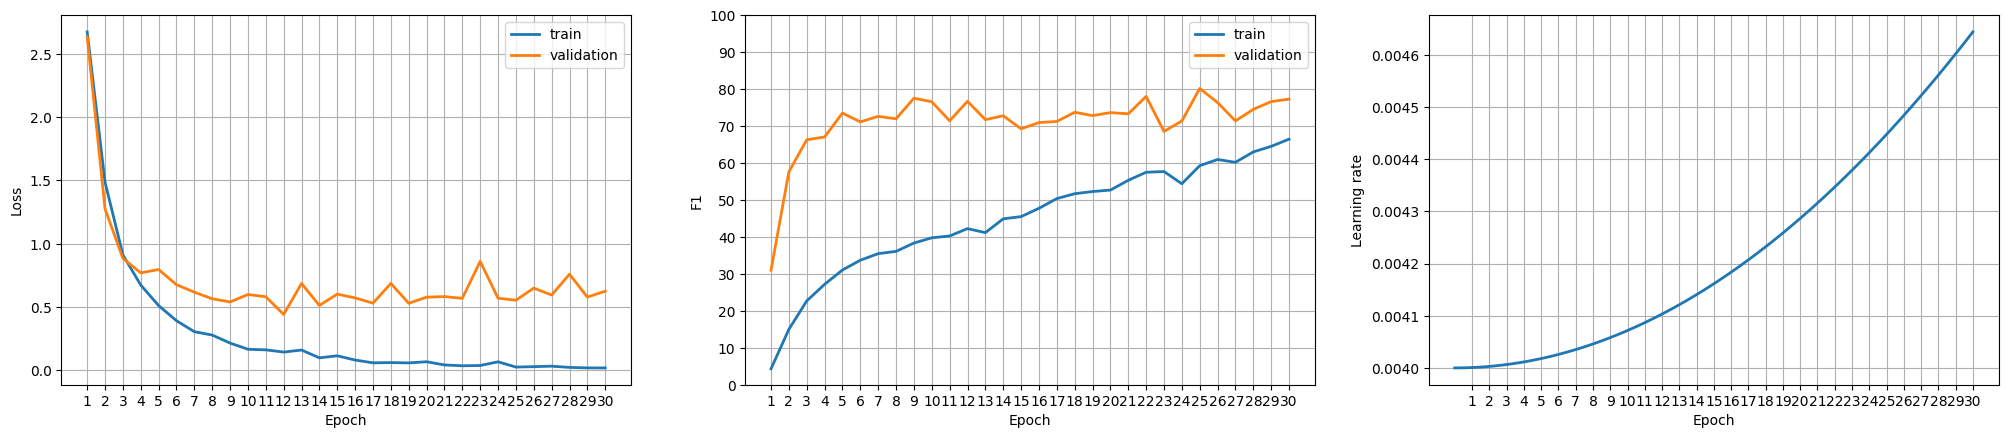

In [62]:
fig, axs = plt.subplots(1, 3)
fig.set_figwidth(25) 

axs[0].plot(range(1, num_epochs + 1), train_losses, linewidth = 2, label = 'train')
axs[0].plot(range(1, num_epochs + 1), val_losses, linewidth = 2, label = 'validation')
axs[0].set_xticks(range(1, num_epochs + 1))
axs[0].set_xlabel('Epoch') 
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid()

axs[1].plot(range(1, num_epochs + 1), train_f1s, linewidth = 2, label = 'train')
axs[1].plot(range(1, num_epochs + 1), val_f1s, linewidth = 2, label = 'validation')
axs[1].set_xticks(range(1, num_epochs + 1))
axs[1].set_yticks(range(0, 101, 10))
axs[1].set_xlabel('Epoch') 
axs[1].set_ylabel('F1')
axs[1].legend()
axs[1].grid()

axs[2].plot(np.linspace(0, num_epochs, len(lrs)), lrs, linewidth = 2)
axs[2].set_xticks(range(1, num_epochs + 1))
axs[2].set_xlabel('Epoch') 
axs[2].set_ylabel('Learning rate')
axs[2].grid()

plt.show()

# Тестирование модели

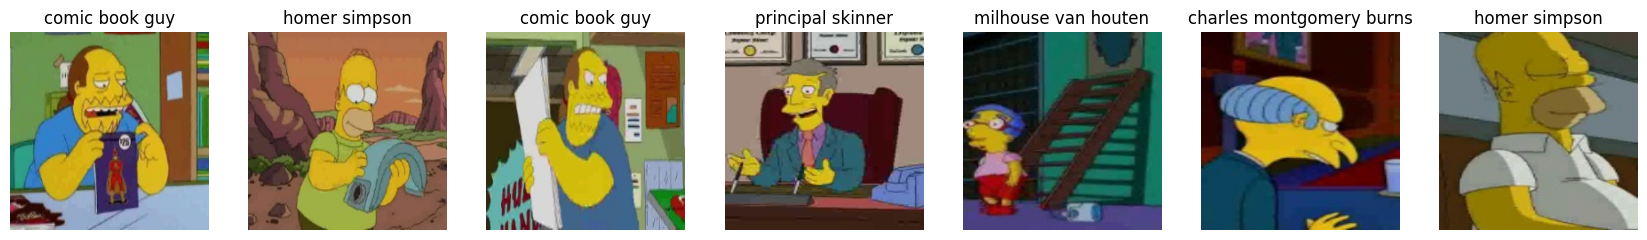

F1-score of the network on the 990 testing images: 82.7136 %


In [63]:
f1 = F1Score(task = 'multiclass', num_classes = len(train_classes), average = 'none').to(device)
net.eval()

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        
        images = images.to(device)

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)

        labels = labels.apply_(lambda num: classes_dict[num]) # Перевести номера тренировочных меток в номера тестовых меток
        labels = labels.to(device)

        f1.update(predicted, labels)
        
        # Отобразить изображения с предсказанными названиями
        if not i:
            imshow(images.cpu(), predicted.cpu(), 7)

        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

    print('F1-score of the network on the {} testing images: {:.4f} %'.format(n_test, 100 * sum(f1.compute()) / len(test_classes)))